<a href="https://colab.research.google.com/github/Tridev-github/Image-caption-generation/blob/main/Predictive_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 494.0 kB/s eta 0:00:00


In [ ]:
!pip install keras pillow numpy tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

<ipython-input-7-1912003fe9ae>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [ ]:
def load_doc(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text

def all_img_captions(filename):
  file = load_doc(filename)
  captions = file.split('\n')
  descriptions ={}
  for caption in captions[:-1]:
    temp = caption.split(',')
    img = temp[0]
    caption = ",".join(temp[1:])
    if img[:-2] not in descriptions:
     descriptions[img[:-2]] = [ caption ]
    else:
      descriptions[img[:-2]].append(caption)
  return descriptions


def cleaning_text(captions):
  table = str.maketrans('','',string.punctuation)
  for img,caps in captions.items():
    for i,img_caption in enumerate(caps):
      img_caption.replace("-"," ")
      desc = img_caption.split()
      desc = [word.lower() for word in desc]
      desc = [word.translate(table) for word in desc]
      desc = [word for word in desc if(len(word)>1)]
      desc = [word for word in desc if(word.isalpha())]
      img_caption = ' '.join(desc)
      captions[img][i]= img_caption
  return captions

def text_vocabulary(descriptions):
  vocab = set()
  for key in descriptions.keys():
    [vocab.update(d.split()) for d in descriptions[key]]
  return vocab

def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [ ]:
dataset_text = "/content/drive/MyDrive/archive"
dataset_images = "/content/drive/MyDrive/archive/Images"
filename = dataset_text + "/" + "captions.txt"
descriptions = all_img_captions(filename)
print("Length of descriptions =" , len(descriptions))

clean_descriptions = cleaning_text(descriptions)

vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

save_descriptions(clean_descriptions, "/content/drive/MyDrive/Project/descriptions.txt")

In [ ]:
def extract_features(directory):
  model = Xception( include_top=False, pooling='avg' )
  features = {}
  for img in tqdm(os.listdir(directory)):
    filename = directory + "/" + img
    image = Image.open(filename)
    image = image.resize((299,299))
    image = np.expand_dims(image, axis=0)
    #image = preprocess_input(image)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    features[img] = feature
  return features


features = extract_features(dataset_images)
dump(features, open("/content/drive/MyDrive/Project/features.p","wb"))

83683744/83683744 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 370ms/step


In [ ]:
def load_photos(filename):
  files = load_doc(filename)

  captions = files.split('\n')
  photos = []
  for caption in captions[:6000]:
    temp = caption.split(',')
    img = temp[0]
    photos.append(img)

  return photos

def load_clean_descriptions(filename, photos):
  files = load_doc(filename)
  descriptions = {}
  for line in files.split("\n"):
    words = line.split('\t')
    if len(words)<1 :
      continue
    image, image_caption = words[0], words[1:]
    image+='pg'
    if image in photos:
      if image not in descriptions:
        descriptions[image] = []
      desc = '<start> ' + " ".join(image_caption) + ' <end>'
      descriptions[image].append(desc)
  return descriptions


def load_features(photos):
    all_features = load(open("/content/drive/MyDrive/Project/features.p","rb"))
    features = {k:all_features[k] for k in photos[1:]}
    return features

filename = dataset_text + "/" + "captions.txt"

train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/Project/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [ ]:
def dict_to_list(descriptions):
  all_desc = []
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
  desc_list = dict_to_list(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(desc_list)
  return tokenizer

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/drive/MyDrive/Project/tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

3579

In [ ]:
def max_length(descriptions):
  desc_list = dict_to_list(descriptions)
  return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
    for key, description_list in descriptions.items():
      feature = features[key][0]
      input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
      yield ([input_image, input_sequence], output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
  X1, X2, y = list(), list(), list()
  for desc in desc_list:
    seq = tokenizer.texts_to_sequences([desc])[0]
    for i in range(1, len(seq)):
      in_seq, out_seq = seq[:i], seq[i]
      in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      X1.append(feature)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(X1), np.array(X2), np.array(y)
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 3579))

In [ ]:
from keras.utils.vis_utils import plot_model

def define_model(vocab_size, max_length):
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  # LSTM sequence model
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  # Merging both models
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # tie it together
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
  print(model.summary())
  plot_model(model, to_file='/content/drive/MyDrive/Project/model.png', show_shapes=True)
  return model

In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
print(model,'model')
epochs = 10
steps = len(train_descriptions)

os.mkdir("/content/drive/MyDrive/Project/models")

for i in range(epochs):
  generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  model.save("/content/drive/MyDrive/Project/models/model_" + str(i) +".h5")

Dataset:  6000
Descriptions: train= 1200
Photos: train= 1200
Vocabulary Size: 3579
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      916224      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


1200/1200 [==============================] - 282s 235ms/step - loss: 2.2364


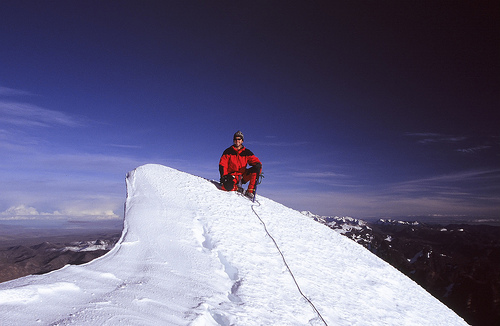

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/archive/Images/55473406_1d2271c1f2.jpg')
img

1/1 [==============================] - 1s 1s/step
start snowboarder skiing down snowy hill end


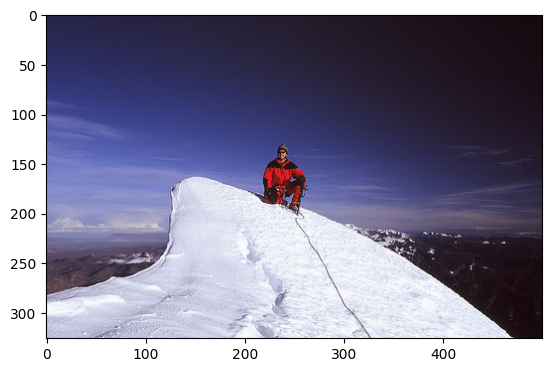

In [ ]:
import numpy as np
from keras_preprocessing.sequence import pad_sequences
from keras import models
from pickle import dump, load
from PIL import Image
import matplotlib.pyplot as plt
import argparse
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4:
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer  .texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
img_path = '/content/drive/MyDrive/archive/Images/55473406_1d2271c1f2.jpg'
max_length = 32
tokenizer = load(open("/content/drive/MyDrive/Project/tokenizer.p","rb"))
model = models.load_model('/content/drive/MyDrive/Project/models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print(description)
plt.imshow(img)

In [ ]:
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

lis_of_cat = ["Vehicles","Music","Pets","Sports", "Travel","Gaming","Comedy"]
text1 = "snowboarder skiing down snowy hill"
tokens = []
for i in lis_of_cat:
  tokens.append(word_tokenize(i))
tokens.append(word_tokenize(text1))

model = Word2Vec(tokens, min_count=1)
print(model)
for i in lis_of_cat:
  val = 0
  for j in text1.split(" "):
    similarity = model.wv.similarity(i,j)
    val+=similarity
  print("Similarity between ",i," and text:", val)



Word2Vec<vocab=12, vector_size=100, alpha=0.025>
Similarity between  Vehicles  and text: 0.2960860896855593
Similarity between  Music  and text: -0.4193431781604886
Similarity between  Pets  and text: -0.2550400495529175
Similarity between  Sports  and text: 0.26578960195183754
Similarity between  Travel  and text: -0.06756753078661859
Similarity between  Gaming  and text: 0.12431957758963108
Similarity between  Comedy  and text: 0.2839774414896965


In [ ]:
import numpy as np
import gensim
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Load Word2Vec pre-trained embeddings
word2vec_model = gensim.downloader.load('glove-twitter-25')

# Define the maximum number of words in a caption
max_caption_length = 40

# Sample data: captions and corresponding hashtags
captions = ["a beautiful sunset over the mountains", "delicious food at the restaurant"]
hashtags = ["#sunset #mountains", "#food #restaurant"]

# Tokenize captions and hashtags
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
caption_sequences = tokenizer.texts_to_sequences(captions)
caption_sequences = pad_sequences(caption_sequences, maxlen=max_caption_length)

# Create input data using Word2Vec embeddings
word2vec_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

# Build the RNN model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, word2vec_dim, weights=[embedding_matrix], input_length=max_caption_length, trainable=False))
model.add(LSTM(100))
model.add(Dense(len(hashtags), activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert hashtags to binary labels
binary_labels = np.array([1 if hashtag in h else 0 for h in hashtags for hashtag in h.split()]).reshape(len(hashtags), -1)

# Train the model
model.fit(caption_sequences, binary_labels, epochs=10)

# Now you can use the model to predict hashtags for new captions.



[==================================================] 100.0% 104.8/104.8MB downloaded
Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5554 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 17ms/step - loss: 0.4816 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 18ms/step - loss: 0.4157 - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 19ms/step - loss: 0.3573 - accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 19ms/step - loss: 0.3056 - accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 25ms/step - loss: 0.2600 - accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 15ms/step - loss: 0.2200 - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 16ms/step - loss: 0.1850 - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 15ms/step - loss: 0.1547 - accuracy: 0.0000e+00
Epoch 10

In [ ]:
new_caption = "stunning view from the top of the mountain"
predictions = predict_hashtags(new_caption, model, tokenizer)
print("Predicted hashtag probabilities:", predictions)

NameError: ignored

In [ ]:
import numpy as np
import gensim
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Function to load Word2Vec embeddings
def load_word2vec_model(model_path):
    try:
        word2vec_model = gensim.downloader.load('glove-twitter-25')
        return word2vec_model
    except Exception as e:
        print(f"Error loading Word2Vec model: {e}")
        return None

# Function to predict hashtags for a new caption
def predict_hashtags(new_caption, model, tokenizer):
    # Tokenize and pad the new caption
    caption_sequence = tokenizer.texts_to_sequences([new_caption])
    caption_sequence = pad_sequences(caption_sequence, maxlen=max_caption_length)

    # Predict hashtags
    predictions = model.predict(caption_sequence)
    return predictions

# Load Word2Vec embeddings
word2vec_model = load_word2vec_model("path_to_word2vec_model.bin")

# Define the maximum number of words in a caption
max_caption_length = 20

# Sample data: captions and corresponding hashtags
captions = ["a beautiful sunset over the mountains", "delicious food at the restaurant"]
hashtags = ["#sunset #mountains", "#food #restaurant"]

# Tokenize captions and hashtags
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
caption_sequences = tokenizer.texts_to_sequences(captions)
caption_sequences = pad_sequences(caption_sequences, maxlen=max_caption_length)

# Create input data using Word2Vec embeddings
word2vec_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

# Build the RNN model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, word2vec_dim, weights=[embedding_matrix], input_length=max_caption_length, trainable=False))
model.add(LSTM(100))
model.add(Dense(len(hashtags), activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert hashtags to binary labels
binary_labels = np.array([1 if hashtag in h else 0 for h in hashtags for hashtag in h.split()]).reshape(len(hashtags), -1)

# Train the model
model.fit(caption_sequences, binary_labels, epochs=10)




Error loading Word2Vec model: module 'gensim' has no attribute 'downloader'


AttributeError: ignored

In [ ]:
# Example usage of the predict_hashtags function
new_caption = "stunning view from the top of the mountain"
predictions = predict_hashtags(new_caption, model, tokenizer)
print("Predicted hashtag probabilities:", predictions)

NameError: ignored

In [ ]:
# Example usage of the predict_hashtags function
new_caption = "stunning view from the top of the mountain"
predictions = predict_hashtags(new_caption, model, tokenizer)

# Get the tokenized words
caption_tokens = tokenizer.texts_to_sequences([new_caption])[0]

# Map probabilities to hashtags
predicted_hashtags = []
for i, probability in enumerate(predictions[0]):
    if probability >= 0.0:  # You can adjust the threshold as needed
        word = tokenizer.index_word[caption_tokens[i]]
        if word not in ['a', 'an', 'the']:  # Exclude common stop words
            predicted_hashtags.append(word)

print("Predicted hashtags:", predicted_hashtags)


1/1 [==============================] - 0s 23ms/step
Predicted hashtags: []


In [ ]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.1 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True